# Settings and imports

#### Imports

In [1]:
import sys
sys.path.append('../my_polycomb_utils')

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc

from pandas.api.types import CategoricalDtype
from copy import copy
from matplotlib import colors
from tqdm import tqdm

import pingouin as pg
from CSCORE import CSCORE

import matplotlib.patches as mpatches
from matplotlib.patches import Patch

from my_scrnaseq_utils import mean_var_plot, grouped_obs_mean

#### Preparing font

In [5]:
from pathlib import Path
from matplotlib import font_manager

# Downloaded in 01_Polycomb_loops_on_HiC_maps.ipynb
fpath=Path("../fonts/Montserrat-Regular.ttf")
fbpath=Path("../fonts/Montserrat-Bold.ttf")
fe = font_manager.FontEntry(fname=fpath, name='Montserrat')
fbe = font_manager.FontEntry(fname=fbpath, name='Montserrat', style='bold', variant='bols', weight='bold')
font_manager.fontManager.ttflist.insert(0, fbe)
font_manager.fontManager.ttflist.insert(0, fe) # or append is fine
font_manager.fontManager.addfont(fbpath)
font_manager.fontManager.addfont(fpath)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Montserrat']

#### Settings

In [6]:
# Set-up suppression of some varnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [7]:
data_dir = '../data/'

## 00: Load and preprocess scRNA-seq data

#### Cell clusters info

- Downloaded from: [cluster_annotation.xlsx](https://github.com/linnarsson-lab/adult-human-brain/raw/main/tables/cluster_annotation.xlsx)

In [8]:
cluster_cols_rename = {'Cluster name': 'cluster_name',
                       'Supercluster': 'supercluster',
                       'Class auto-annotation': 'class_auto_annotation',
                       'Neurotransmitter auto-annotation': 'neurotransmitter_auto_annotation',
                       'Neuropeptide auto-annotation': 'neuropeptide_auto_annotation',
                       'Subtype auto-annotation': 'subtype_auto_annotation',
                       'Fraction unspliced': 'fraction_unspliced'}

In [9]:
clusters_abbrevs = pd.read_csv(data_dir + 'clusters_abbrevs.csv', header=None)
clusters_raw = pd.read_excel(data_dir + 'cluster_annotation.xlsx').dropna(subset='Cluster ID')
clusters_raw['Cluster ID'] = clusters_raw['Cluster ID'].astype(int)
clusters_raw = clusters_raw.set_index('Cluster ID')
clusters_raw = clusters_raw.loc[:, cluster_cols_rename.keys()].rename(cluster_cols_rename, axis=1)

#### Cell types info

In [10]:
celltypes_order = ['Neuron', 'Astrocyte', 'Oligodendrocyte', 'Oligodendrocyte precursor', 'Microglia']
celltypes_colors = {'Neuron': '#56009c',
                   'Astrocyte': '#3a78a2',
                   'Oligodendrocyte': '#e08803',
                   'Oligodendrocyte precursor': '#fcc674',
                   'Microglia': '#9db607'
                  }

#### Polycomb genes info

In [11]:
pkgs_types_order = ['Core', 'cPRC1', 'ncPRC1', 'PRC2.1', 'PRC2.2', 'Auxillary']
pkgs_types_colors = {'Core': '#56009c',
                     'cPRC1': '#e08803',
                     'ncPRC1': '#fcc674',
                     'PRC2.1': '#9db607',
                     'PRC2.2': '#d2de26',
                     'Auxillary': 'grey',
}

In [12]:
polycombs = pd.read_csv(data_dir + 'polycomb_subunits.tsv', sep='\t')
polycombs = polycombs.set_index('Ensembl_ID')
polycombs = polycombs[~polycombs.Name.isin(['BCORL1', 'EZHIP', 'RBBP7', 'SCML1', 'SCML2'])] # remove genes absent in scRNAseq siletti
polycombs['Type'] = polycombs['Type'].astype(CategoricalDtype(pkgs_types_order, ordered=True))

In [13]:
# AUTS2 is quite outstanding, but it's an Auxillary subunit, so remove it

pkgs_genes_colors_map = polycombs.set_index('Name').Type.apply(lambda x: pkgs_types_colors[x])
prc_genes_map = polycombs.reset_index(drop=False)[['Name', 'Type']].query('Name!="AUTS2"').groupby('Type').agg(list).to_dict()['Name']
prc1_genes_map = polycombs.query('Complex=="PRC1"').reset_index(drop=False)[['Name', 'Type']].groupby('Type').agg(list).to_dict()['Name']
prc2_genes_map = polycombs.query('Complex=="PRC2"').reset_index(drop=False)[['Name', 'Type']].groupby('Type').agg(list).to_dict()['Name']

#### scRNA-seq adata, read and preprocess

In [14]:
adata = sc.read_h5ad(data_dir + '6323dc85-7d67-4640-a407-c9724877f412.h5ad')
adata.obsm['X_umap'] = adata.obsm['X_UMAP']

In [15]:
adata

AnnData object with n_obs × n_vars = 40565 × 59357
    obs: 'roi', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'supercluster_term', 'cluster_id', 'subcluster_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'Biotype', 'Chromosome', 'End', 'Gene', 'Start', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'batch_condition', 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_UMAP', 'X_tSNE', 'X_umap'

##### Filter cell types

In [16]:
superclusters_to_drop = ['Vascular', 'Fibroblast', 'Choroid plexus']
autoclasses_to_drop = ['BCELL', 'TCELL', 'MONO', 'NK', 'CHRP', 'ENDO', 'ERY', 'FIB', 'MAC', 'PER', 'VSMC']

clusters = clusters_raw.query('supercluster not in @superclusters_to_drop') \
                       .query('class_auto_annotation not in @autoclasses_to_drop') 
clusters.class_auto_annotation = clusters.class_auto_annotation.fillna('NEUR')
selected_clusters_ids = clusters.index.to_list()

adata = adata[adata.obs.cluster_id.isin(selected_clusters_ids), :]

##### Rename cell types

In [17]:
adata.obs.cell_type = adata.obs.cell_type \
                               .cat.rename_categories({'central nervous system macrophage': 'microglia',
                                                       'oligodendrocyte precursor cell': 'oligodendrocyte precursor'}) \
                               .cat.rename_categories(lambda x: x.capitalize())

##### Preprocess genes names

In [18]:
# For some of the PcG genes names are inconsistent 
polycombs[['Name']].join(adata.var[['Gene']]).query('Name != Gene')

,Name,Gene
Ensembl_ID,,
ENSG00000204227,RING1A,RING1
ENSG00000121481,RING1B,RNF2
ENSG00000168283,PCGF4,BMI1
ENSG00000010803,SCML3,SCMH1
ENSG00000163935,SFMBT,SFMBT1


In [19]:
adata.var.Gene = adata.var.Gene.astype(str)

for idx, (right_name, wrong_name) in polycombs[['Name']].join(adata.var[['Gene']]).query('Name != Gene').iterrows():
    adata.var.loc[idx, 'Gene'] = right_name

adata.var = adata.var.reset_index(drop=False).set_index('Gene', drop=False)
adata.var_names_make_unique()

##### Filter out chromosomes: keep only chr1 - chr22 and their contigs

In [20]:
chrs = tuple(['chr'+str(i) for i in range(1, 23)])
adata.var.Chromosome = adata.var.Chromosome.cat.remove_categories([c for c in adata.var.Chromosome.cat.categories if not c.startswith(chrs)])
adata = adata[:,adata.var.Chromosome.notna()]

##### Add polycombs info

In [21]:
adata.var = adata.var.join(polycombs.set_index('Name'))

##### Inspect cell types

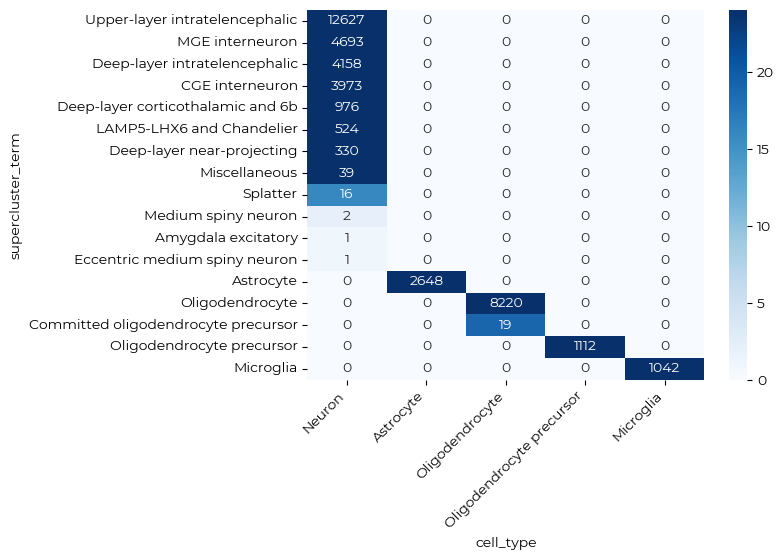

In [22]:
ct = pd.crosstab(adata.obs['cell_type'], adata.obs['supercluster_term']).T.sort_values(by=celltypes_order, ascending=False).loc[:,celltypes_order]

sns.heatmap(ct, 
            cmap = 'Blues',
            vmax = 24, vmin=0,
            annot = True, fmt='g'
           )
plt.xticks(rotation=45, ha='right');

In [23]:
adata.write(data_dir + 'STG_Neurons_and_Glia_Filtered_RawCounts.h5ad', compression="gzip")

##### QC and normalise

In [24]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

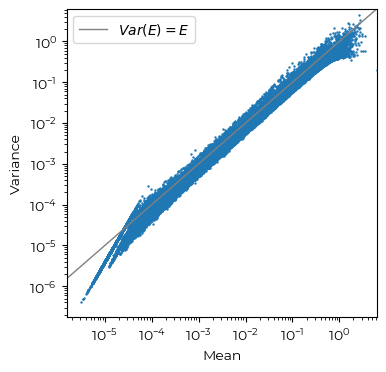

In [25]:
mean_var_plot(adata, log=True)

In [26]:
adata.write(data_dir + 'STG_Neurons_and_Glia_Filtered_log1pCP1K.h5ad', compression="gzip")

# 01: Polycomb expresson in single cells

**Figures in thesis:**
- `Figure 9`: (I) STG cells PCA, (II) Mean-variance plot, (III) PcG expressions
- `Figure 10`: (IV) PcG expressions by cell type

### _01 (I)  STG cells PCA

In [25]:
sc.tl.pca(adata, n_comps=10)

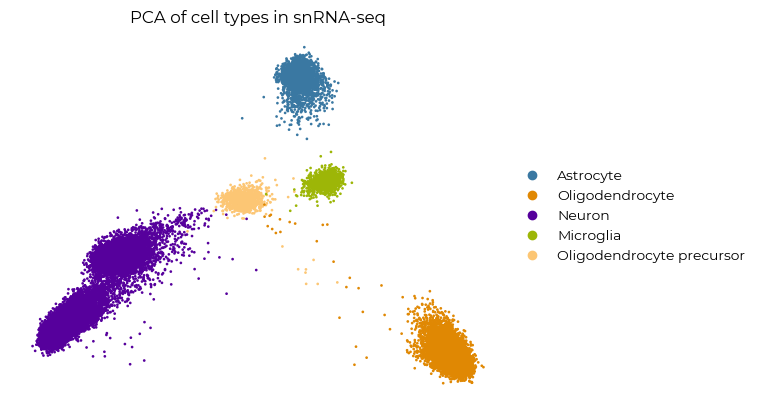

In [26]:
sc.pl.pca(adata, color='cell_type', frameon=False, size=15, palette=celltypes_colors, title='PCA of cell types in snRNA-seq')

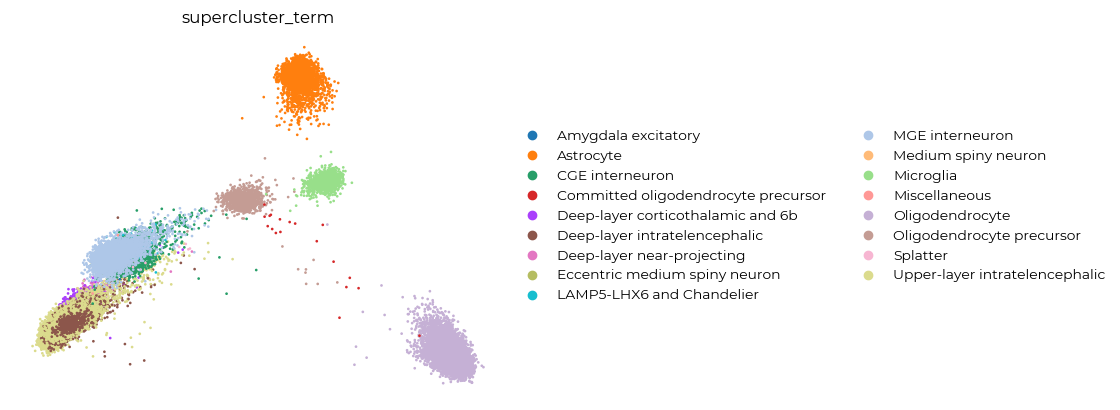

In [27]:
sc.pl.pca(adata, color='supercluster_term', frameon=False, size=15)

### _01 (II)  Mean-variance plot

In [28]:
sc.pp.highly_variable_genes(adata, n_top_genes=5000)
highly_variable_genes = adata.var[adata.var.highly_variable].index

In [29]:
highly_variable_genes = adata.var[['highly_variable', 'means', 'dispersions_norm', 'dispersions', 'Gene', 'Type']] \
                             .dropna(subset=['dispersions_norm']) \
                             .sort_values(by='dispersions_norm', ascending=False)
highly_variable_genes['Is_Polycomb'] = highly_variable_genes['Type'].notna()

top_genes_cutoffs = dict()
for n_top in [1000, 3000, 5000]:
    cutoff = highly_variable_genes.sort_values(by='dispersions_norm', ascending=False)\
                                  .head(n_top).tail(1).dispersions_norm[0]
    top_genes_cutoffs[n_top] = cutoff

top_polycombs = highly_variable_genes.query('(dispersions_norm >  @top_genes_cutoffs[5000] or means > 1.1)  and Is_Polycomb')

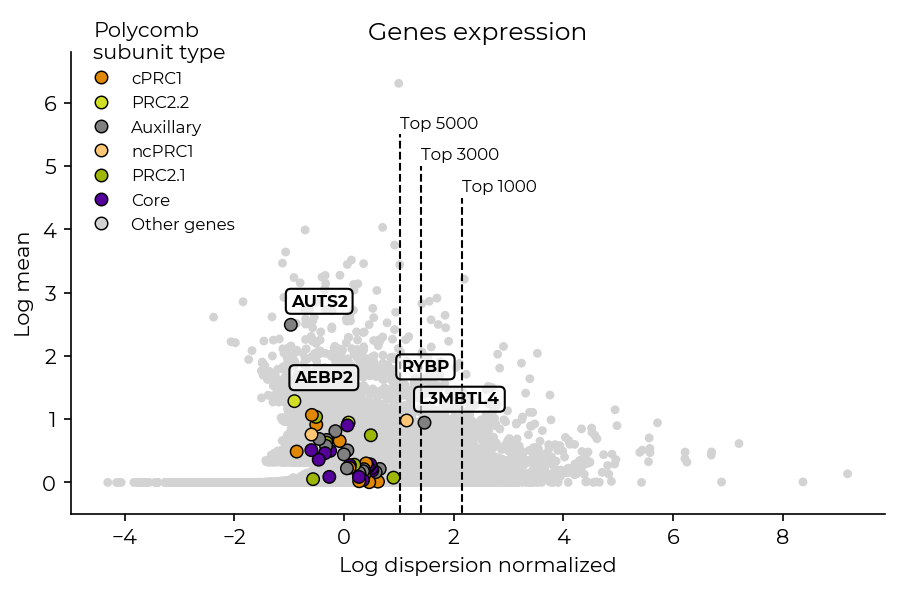

In [30]:
fig = plt.figure(figsize=(7, 4), dpi=150)


## All other genes scatterplot ##
sns.scatterplot(highly_variable_genes.query('not Is_Polycomb') , y='means', x='dispersions_norm', 
                color='lightgrey', linewidth=0, size=0.1,
                zorder=1,
                legend=False)

## Threshold lines ##
for i, (n_top, cutoff) in enumerate(top_genes_cutoffs.items()):
    plt.vlines(cutoff, -1, 4.5+i/2, color='k', linestyle='--', linewidth=1)
    plt.text(cutoff, 4.5+i/2+0.1, 
             f'Top {n_top}',
             color='black', fontsize=8,
             zorder=5)

## PcG genes scatterplot ##
sns.scatterplot(highly_variable_genes.query('Is_Polycomb') , y='means', x='dispersions_norm', 
                hue="Type", palette=(pkgs_types_colors | {np.nan:'black', 'Other genes': 'lightgrey'}),
                linewidth=0.7, edgecolor='k',
                zorder=10)

##  Legend ##
handles, labels = plt.gca().get_legend_handles_labels() 
new_handle = copy(handles[0]) # Other genes
new_handle.set_markerfacecolor('lightgrey')
order = [1, 4, 5, 2, 3, 0] 
legend_items = [handles[i] for i in order] + [new_handle], [labels[i] for i in order] + ['Other genes']
plt.legend(*legend_items,
           title='Polycomb\nsubunit type',
           bbox_to_anchor=(0.22, 1.1), loc='upper right', 
           fontsize=8, title_fontsize=10, frameon=False
          )

## Annotation of some PcG genes ##
fc = colors.to_rgba('white')
ec = colors.to_rgba('black')
fc = fc[:-1] + (0.6,) 
bbox = dict(boxstyle='round',facecolor=fc, edgecolor=ec)
for i, (gene, info) in enumerate(top_polycombs.iterrows()):
    xy = (info.dispersions_norm, info.means)
    if info.dispersions_norm > top_genes_cutoffs[5000]:
        shift_x, shift_y = -0.1, 0.3 + i/2.1
    else:
        shift_x, shift_y = 0, 0.3
    xytext = (xy[0]+shift_x, xy[1]+shift_y)
    plt.annotate(gene, xy=xy, xytext = xytext,
                 bbox=bbox,
                 fontsize=8, fontweight='bold'
                )

plt.gca().spines[['right', 'top']].set_visible(False)
plt.ylim(-0.5, 6.8)
plt.xlabel('Log dispersion normalized')
plt.ylabel('Log mean')
plt.title('Genes expression');

### _01 (III) PcG expressions

In [35]:
pcgs_expressions = pd.DataFrame(adata[:, polycombs.Name.to_list()].X.A,
                                columns =polycombs.Name.to_list(),
                                index = adata.obs.index)
pcg_exprs_for_boxes = pcgs_expressions.melt(ignore_index=False)\
                                      .set_index('variable', drop=False)\
                                      .join(polycombs.set_index('Name')[['Type']]\
                                      .sort_values(by='Type'))

In [40]:
pcg_exprs_for_boxes.Type

AEBP2    PRC2.2
AEBP2    PRC2.2
AEBP2    PRC2.2
AEBP2    PRC2.2
AEBP2    PRC2.2
          ...  
YAF2     ncPRC1
YAF2     ncPRC1
YAF2     ncPRC1
YAF2     ncPRC1
YAF2     ncPRC1
Name: Type, Length: 1978669, dtype: category
Categories (6, object): ['Core' < 'cPRC1' < 'ncPRC1' < 'PRC2.1' < 'PRC2.2' < 'Auxillary']

Text(0, 0.5, 'log(expression +1)')

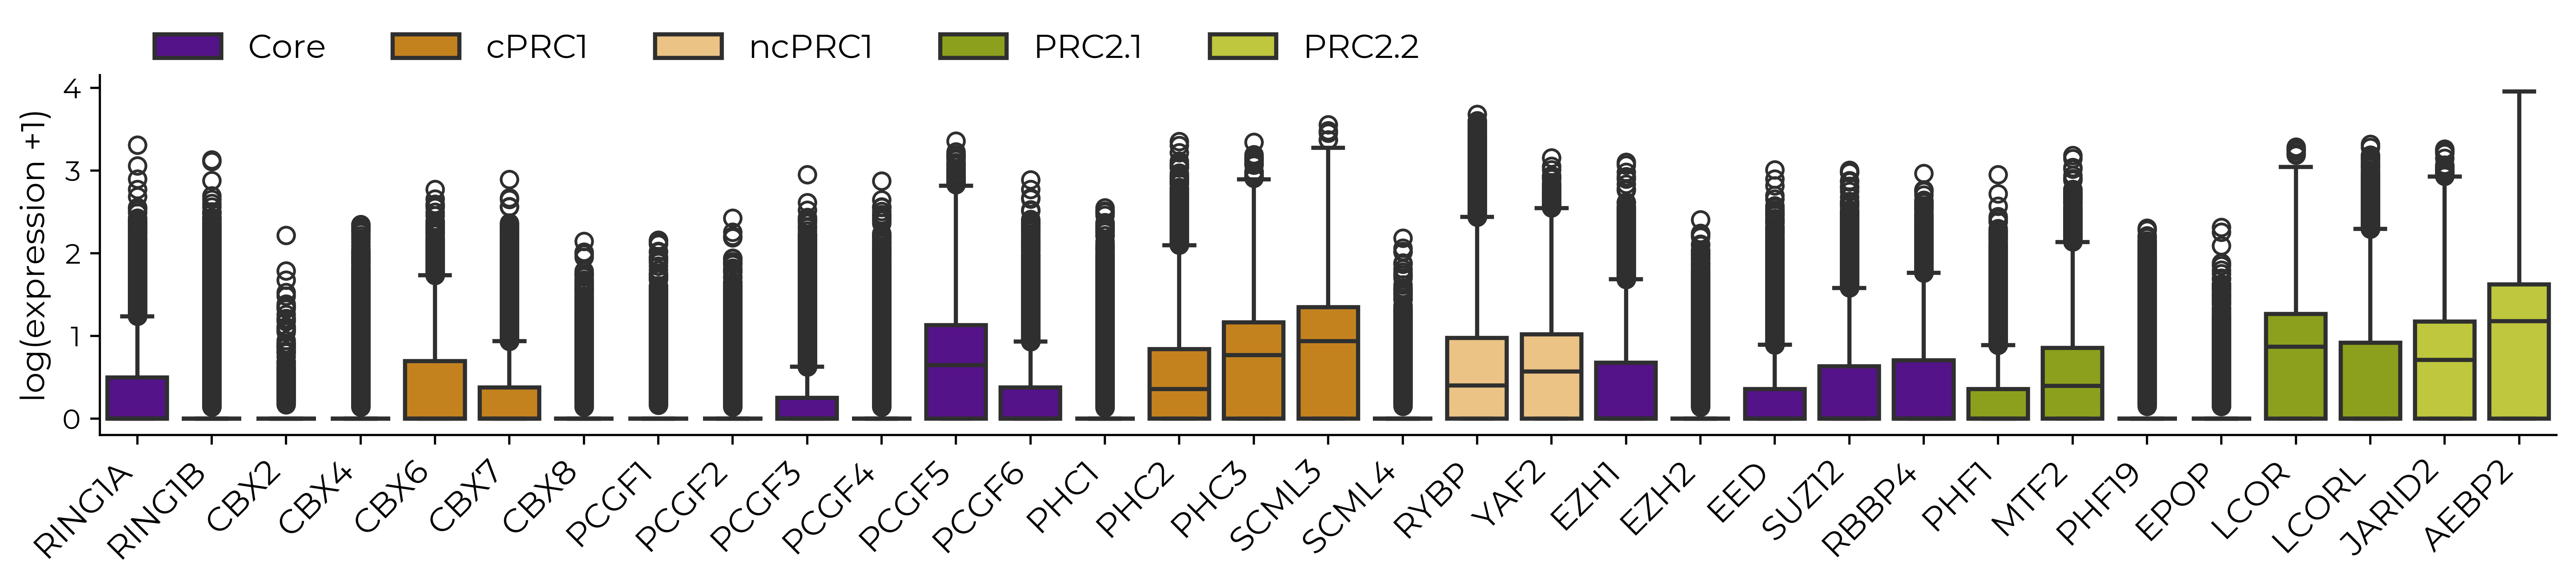

In [45]:
plt.figure(figsize=(13, 3), dpi=500, layout='tight')

sns.boxplot(pcg_exprs_for_boxes.query('Type!="Auxillary"'),
            order = polycombs.query('Type!="Auxillary"').Name.to_list(),
            x = 'variable', y='value', 
            hue = 'Type', palette = pkgs_types_colors, 
            linewidth=1.5)

hs, ls = plt.gca().get_legend_handles_labels()
plt.legend(hs[:-1], ls[:-1], bbox_to_anchor=(0.01, 1.2), 
           loc='upper left', ncols=6, fontsize=12, frameon=False)
plt.gca().spines[['right', 'top']].set_visible(False)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel('')
plt.ylabel('log(expression +1)', fontsize=12)

### _01 (IV) PcG expressions by cell type

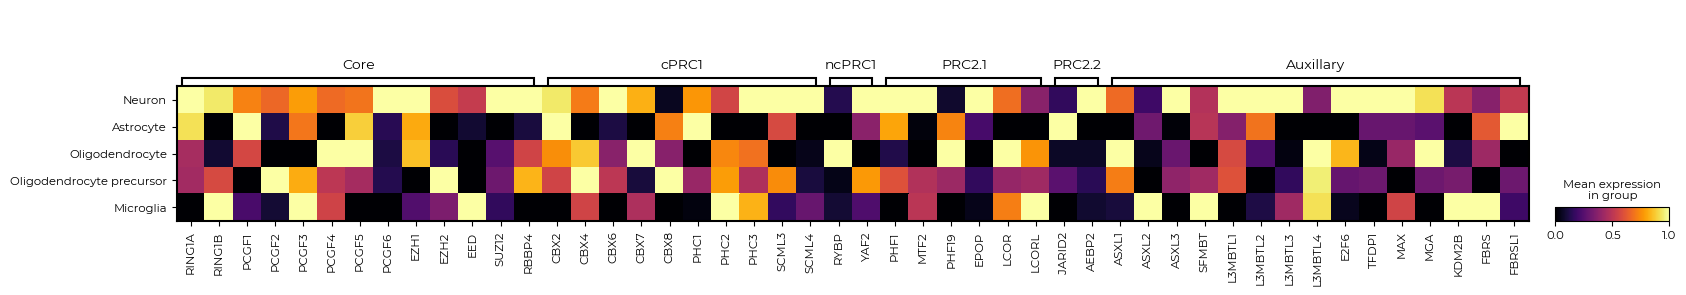

In [31]:
(
    sc.pl.MatrixPlot(adata, 
                   var_names = prc_genes_map, 
                   groupby='cell_type', 
                   categories_order=celltypes_order,
                   var_group_rotation=0,
                   standard_scale='var'
                   )
         .style(cmap='inferno', edge_color='none', edge_lw=0)
         .show()
)

# 02: Polycomb co-expression

**Figures in thesis:**
- `Figure 11`: (I) Cell types correlation, (II) Polycomb genes correlation

### _02 (I) Cell types correlation

In [46]:
from scanpy.tools import _top_genes
from scanpy.plotting import _anndata

In [47]:
_top_genes.correlation_matrix(adata, polycombs.Name.to_list(), 
                              annotation_key=None, method='pearson',
                              n_genes=50)

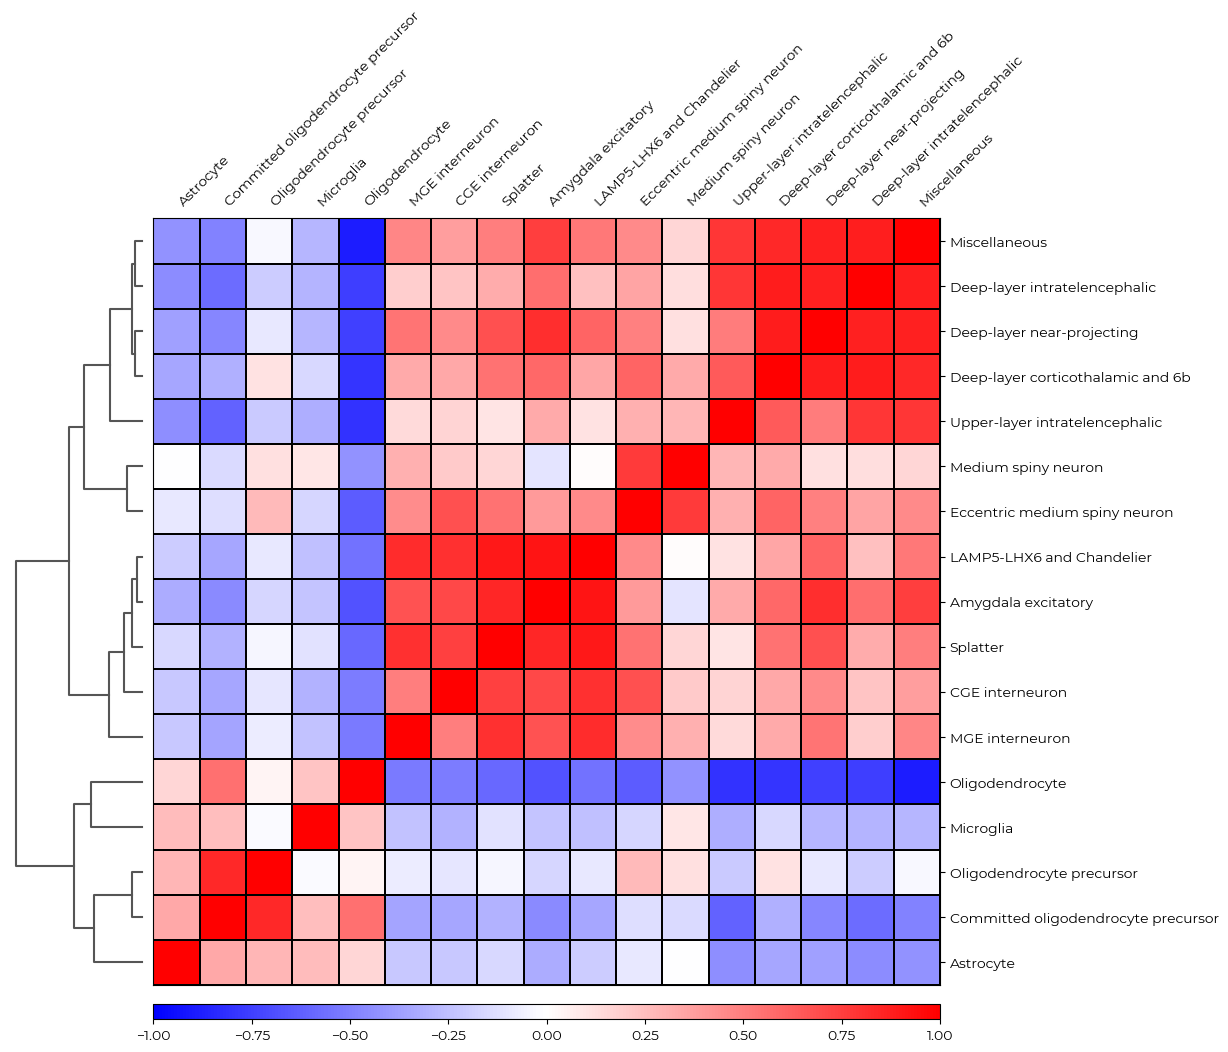

In [48]:
_anndata.correlation_matrix(adata, groupby='supercluster_term')

### _02 (II) Polycomb genes correlation

In [52]:
adata_polycomb_by_st = grouped_obs_mean(adata, 'supercluster_term')

<Figure size 5000x5000 with 0 Axes>

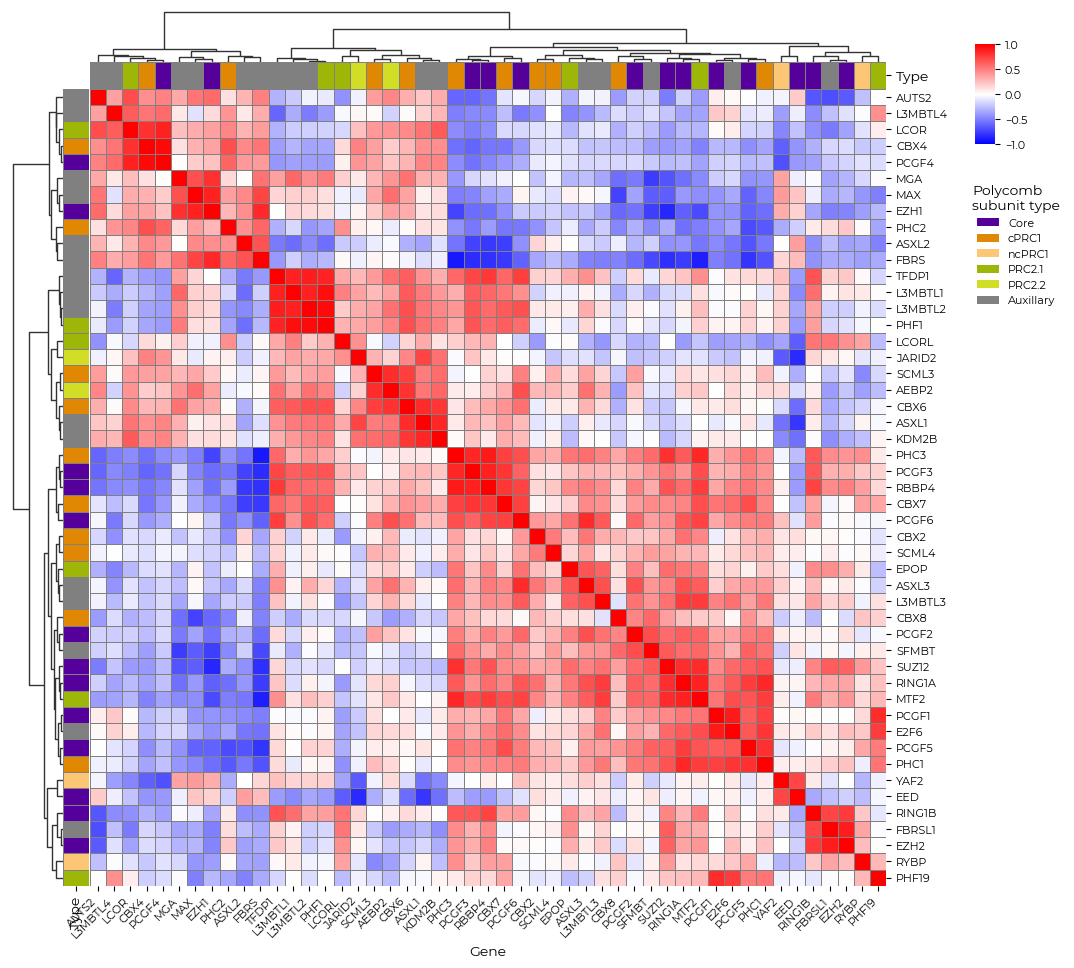

In [59]:
fig = plt.figure(figsize=(25, 25), dpi=200)

pcgs_expressions = adata_polycomb_by_st.T.loc[:, polycombs.Name.to_list()]

cm = sns.clustermap(pcgs_expressions.corr(), 
                    method='ward',
                    cmap = 'bwr', vmax=1, vmin=-1, 
                    col_colors = pkgs_genes_colors_map,
                    row_colors = pkgs_genes_colors_map,
                    dendrogram_ratio=(.06, .06),
                    cbar_pos=(0.98, .85, .02, .1),
                    xticklabels=True, yticklabels=True,
                    linewidth=0.5, linecolor='grey',
                    tree_kws={'linewidth': 1}
                   )

handles = [Patch(facecolor=color) for color in pkgs_types_colors.values()]
plt.legend(handles, pkgs_types_colors, title='Polycomb\nsubunit type',
           bbox_to_anchor=(1.075, .82), bbox_transform=plt.gcf().transFigure, 
           loc='upper right', fontsize=8, title_fontsize=10, frameon=False
          )

plt.setp(cm.ax_heatmap.get_xticklabels(), rotation=45, fontsize=8, ha='right') 
plt.setp(cm.ax_heatmap.get_yticklabels(), fontsize=8) 
cm.ax_heatmap.set_xlabel(xlabel='Gene', fontsize=10)
cm.ax_heatmap.set_ylabel(ylabel='', fontsize=10)
plt.tick_params(labelsize = 8)


# 03: Polycomb expression in cell-subtypes

**Figures in thesis:**
- `Figure 12`: (I) PcG expression in Neurons/Glia, (II) PcG expression in excitatory/inhibitory neurons

### _03 (I) PcG expression in Neurons/Glia

In [60]:
cts_colors =  {'Neuron':  '#c3a5dc',
               'Glia':  '#fcc674'
              }

In [61]:
# Annotatecell types: neurons and glia
adata.obs['cell_type_coarse'] = (adata.obs['cell_type'] == 'Neuron').map({True: 'Neuron', False: 'Glia'})

In [62]:
# Get expressions
polycombs_selected = polycombs.query('Type!="Auxillary"').Name.to_list()

df = pd.DataFrame(columns=['gene', 'cell_type', 'expression'])
for idx, gene in enumerate(polycombs_selected):
    for i, cell_type in enumerate(adata.obs['cell_type_coarse'].unique()):
        subset = adata[adata.obs['cell_type_coarse'] == cell_type, 
                       adata.var_names == gene]
        expression = subset.X.A.ravel()
        df.loc[len(df)] = [gene, cell_type, expression]
df = df.explode('expression')

df['expression'] = df['expression'].astype('float')
df['cell_type'] = df['cell_type'].astype('category')

In [74]:
# Get stat. signif
df_pvals = pd.DataFrame(columns=['gene',  'logFC', 'pval'])
ct1, ct2 = df['cell_type'].unique()
for gene in tqdm(df['gene'].unique()):
    df_gene = df.query("gene==@gene")
    fc = np.mean(df_gene.query("cell_type==@ct1").expression)/np.mean(df_gene.query("cell_type==@ct2").expression)
    logfc = np.log2(fc)
    test_res = pg.mwu(df_gene.query("cell_type==@ct1").expression, df_gene.query("cell_type==@ct2").expression)
    df_pvals.loc[len(df_pvals)] = [gene, logfc, test_res['p-val'][0]]
df_pvals[['signif', 'pval_corr']] = pd.DataFrame(pg.multicomp(df_pvals.pval)).T
df_pvals = df_pvals.set_index('gene')

100%|██████████| 33/33 [08:40<00:00, 15.77s/it]


In [90]:
def plot_genes_exprs(sub_df, ordered_palette=None):
    plt.figure(figsize=(0.8*len(genes_to_plot), 5))
    width, gap = 0.8, 0.3
    sns.boxplot(sub_df, x='gene', y='expression', 
                hue='cell_type', palette=ordered_palette,
                hue_order = ordered_palette.keys(),
                saturation=1, linecolor='k',linewidth=1, 
                width=width, dodge=True, gap=gap,
    )
    
    
    for gene in sub_df['gene'].unique():
        pval_corr = df_pvals.loc[gene]['pval_corr']
        signif = df_pvals.loc[gene]['signif']
        logfc = df_pvals.loc[gene]['logFC']
        
        colors_pval = {True: '#c20000',
                      False: 'black'}
        colors_logfc = {True: 'black',
                       False: 'black'}
        
        x = sub_df['gene'].unique().tolist().index(gene)
        y = sub_df.query('gene==@gene').expression.max() + 0.7
        x1, x2 = x - gap + 0.1, x + gap - 0.1
        h1, h2 = 0.1, 0.1
        y1, y2 = y - h1, y - h1 - h2
        
        plt.plot([x1, x1, x2, x2], [y2, y1, y1, y2], 
                 lw=1.5, c='black')
        plt.text(x=x, y=y+0.25,
                 s=f'p = {pval_corr:.2f}', 
                 color=colors_pval[signif], fontsize=10,
                 ha='center', va='bottom',
                 )
        plt.text(x=x, y=y,
                 s=f'lFC = {logfc:.1f}', 
                 color=colors_logfc[logfc>0], fontsize=10,
                 ha='center', va='bottom',
                 )
    
    fsz_1, fsz_2 = 20, 18
    plt.legend(title=None, loc='upper left', bbox_to_anchor=(0.009, 1.3),
              fontsize=fsz_2, title_fontsize=fsz_1, frameon=False)
    plt.xlabel(None)
    plt.ylabel('Expression', fontsize=fsz_1)
    plt.gca().tick_params(axis='both', which='major', labelsize=fsz_2)
    plt.xticks(rotation=45, ha='right')
    ymin, ymax = plt.gca().get_ylim()
    plt.ylim(ymin, ymax+0.5)
    plt.gca().spines[['right', 'top']].set_visible(False)
    
    plt.tight_layout()

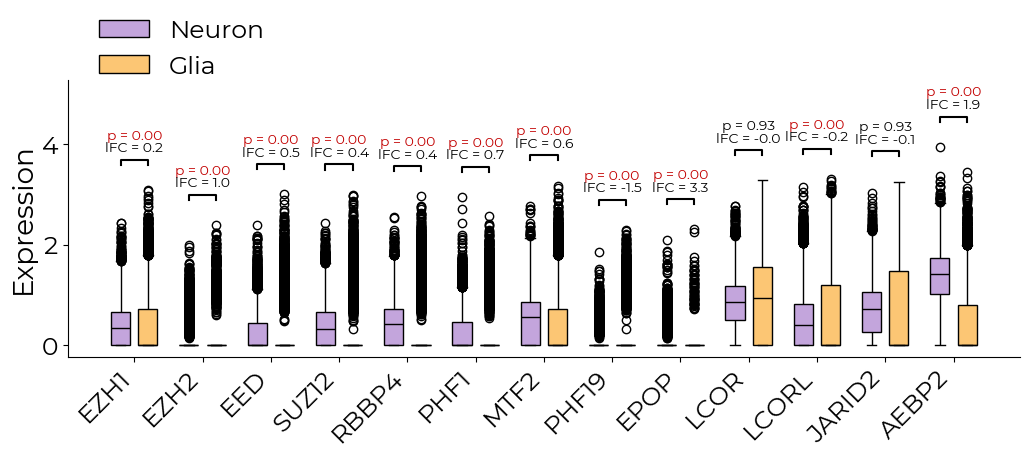

In [82]:
genes_to_plot = polycombs.query('Type!="Auxillary"').query('Complex=="PRC2"').Name.to_list()
sub_df = df.query('gene.isin(@genes_to_plot)')

plot_genes_exprs(sub_df, ordered_palette = cts_colors)

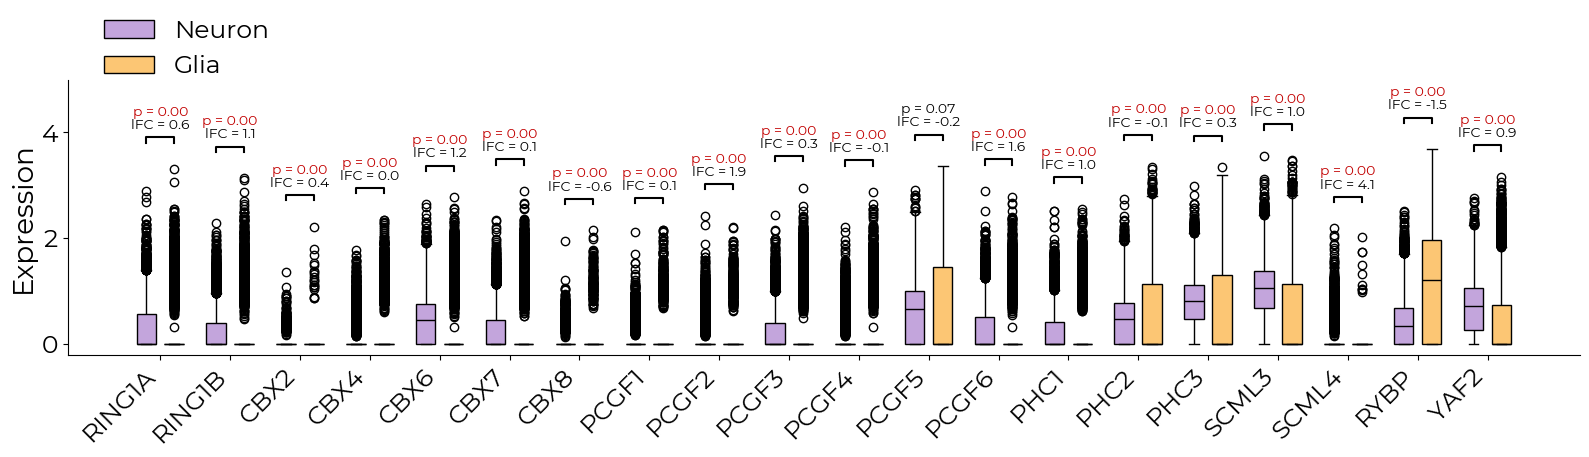

In [83]:
genes_to_plot = polycombs.query('Type!="Auxillary"').query('Complex=="PRC1"').Name.to_list()
sub_df = df.query('gene.isin(@genes_to_plot)')

plot_genes_exprs(sub_df, ordered_palette = cts_colors)

### _03 (II) PcG expression in excitatory/inhibitory neurons

In [84]:
neu_cts_colors =  {'GABA':  '#ffacacff',
                   'GLUT':  '#ace2ffff'
                  }

In [85]:
# Annotate neurons types: GABA ang GLU
adata.obs = pd.merge(adata.obs.iloc[:, :], clusters_raw.reset_index(drop=False,names='cluster_id'), on='cluster_id', how='left').set_index(adata.obs.index)
adata_neurotransm = adata[adata.obs['neurotransmitter_auto_annotation'].isin(['GABA', 'VGLUT1', 'VGUT1 VGLUT2'])]
adata_neurotransm.obs['neurotransmitter_coarse'] = (adata_neurotransm.obs['neurotransmitter_auto_annotation'] == 'GABA').map({True: 'GABA', False: 'GLUT'})

In [88]:
# Get expressions
polycombs_selected = polycombs.query('Type!="Auxillary"').Name.to_list()

df = pd.DataFrame(columns=['gene', 'cell_type', 'expression'])
for idx, gene in enumerate(polycombs_selected):
    for i, cell_type in enumerate(adata_neurotransm.obs['neurotransmitter_coarse'].unique()):
        subset = adata_neurotransm[adata_neurotransm.obs['neurotransmitter_coarse'] == cell_type, 
                       adata_neurotransm.var_names == gene]
        expression = subset.X.A.ravel()
        df.loc[len(df)] = [gene, cell_type, expression]
df = df.explode('expression')

df['expression'] = df['expression'].astype('float')
df['cell_type'] = df['cell_type'].astype('category')

In [89]:
# Get stat. signif
df_pvals = pd.DataFrame(columns=['gene',  'logFC', 'pval'])
ct1, ct2 = df['cell_type'].unique()
for gene in tqdm(df['gene'].unique()):
    df_gene = df.query("gene==@gene")
    fc = np.mean(df_gene.query("cell_type==@ct1").expression)/np.mean(df_gene.query("cell_type==@ct2").expression)
    logfc = np.log2(fc)
    test_res = pg.mwu(df_gene.query("cell_type==@ct1").expression, df_gene.query("cell_type==@ct2").expression)
    df_pvals.loc[len(df_pvals)] = [gene, logfc, test_res['p-val'][0]]
df_pvals[['signif', 'pval_corr']] = pd.DataFrame(pg.multicomp(df_pvals.pval)).T
df_pvals = df_pvals.set_index('gene')

100%|██████████| 33/33 [00:20<00:00,  1.60it/s]


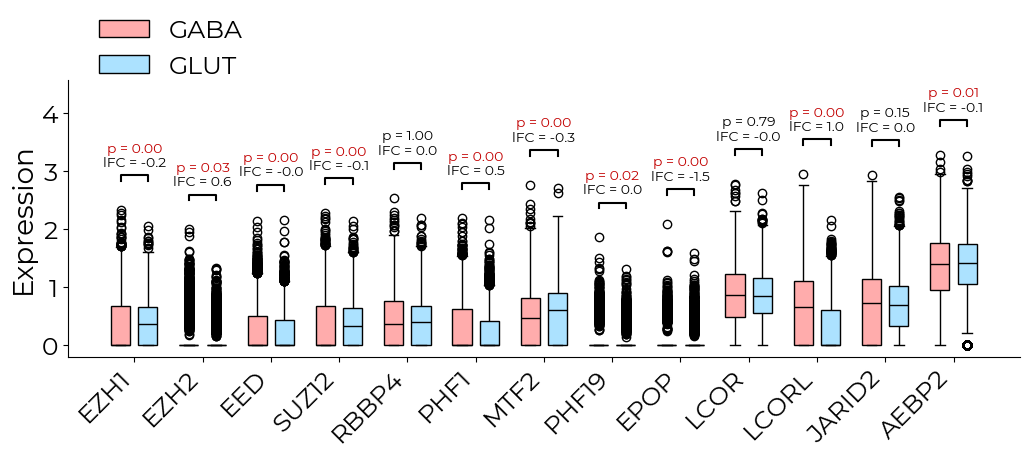

In [91]:
genes_to_plot = polycombs.query('Type!="Auxillary"').query('Complex=="PRC2"').Name.to_list()
sub_df = df.query('gene.isin(@genes_to_plot)')

plot_genes_exprs(sub_df, ordered_palette = neu_cts_colors)

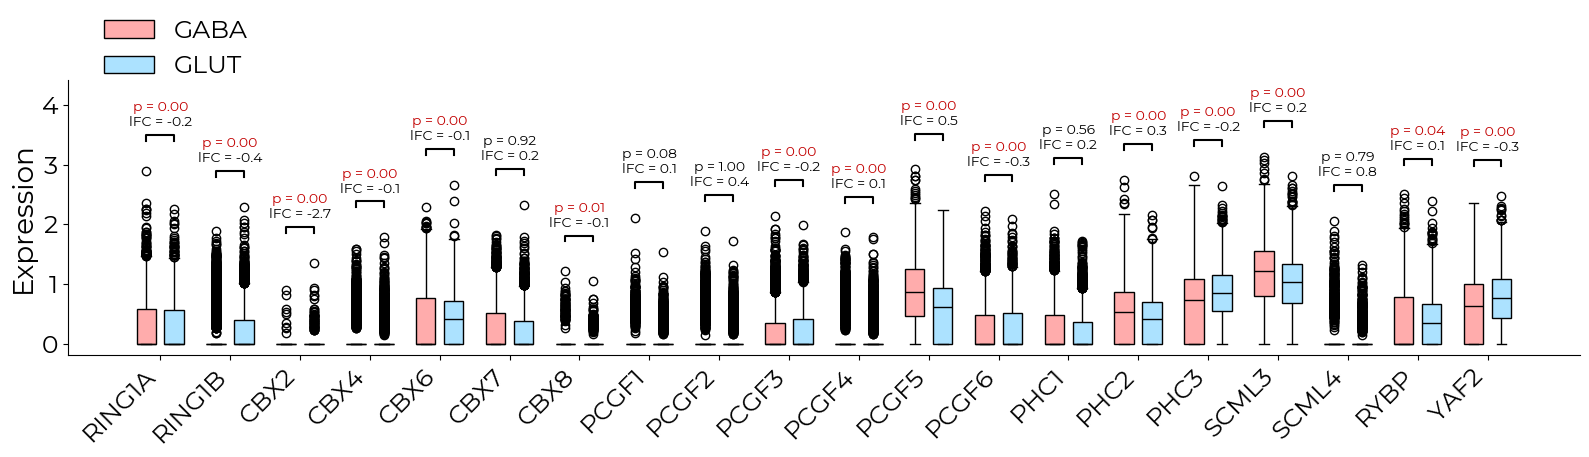

In [92]:
genes_to_plot = polycombs.query('Type!="Auxillary"').query('Complex=="PRC1"').Name.to_list()
sub_df = df.query('gene.isin(@genes_to_plot)')

plot_genes_exprs(sub_df, ordered_palette = neu_cts_colors)

# 04: Polycomb genes vs. Polycomb target genes co-expression

**Figures in thesis:**
- `Figure 13`: (I) Coexpression matrix

In [29]:
adata = sc.read_h5ad(data_dir + 'STG_Neurons_and_Glia_Filtered_log1pCP1K.h5ad')
adata.var['Gene'] = adata.var['Gene'].astype('str')
adata.var = adata.var.reset_index(drop=True).set_index('Gene')
adata.var_names_make_unique()

In [30]:
adata_raw = sc.read_h5ad(data_dir + 'STG_Neurons_and_Glia_Filtered_RawCounts.h5ad')
adata_raw.var['Gene'] = adata_raw.var['Gene'].astype('str')
adata_raw.var = adata_raw.var.reset_index(drop=True).set_index('Gene')
adata_raw.var_names_make_unique()

### Run CSCORE to compute coexpression

#### Get genes to include in analysis

In [31]:
polycomb_anchors = pd.read_table(data_dir + "polycomb_anchors_nick_anno_500bp_promoter.tsv", 
                          names=['chrom', 'start', 'end', 'gene', 'gene_id'], header=0)
genes = sum([[genes] if (';' not in str(genes)) else genes.split(';') for genes in polycomb_anchors.gene.tolist() ], [])
genes = [gene for gene in genes if str(gene) != 'nan']

gene_ids = sum([[genes] if (';' not in str(genes)) else genes.split(';') for genes in polycomb_anchors.gene_id.tolist() ], [])
gene_ids = [gene for gene in gene_ids if str(gene) != 'nan']
gene_ids = list(map(lambda x: x.split('.')[0], gene_ids))

Filter genes with less then 20 non-zero cells

In [32]:
good_genes = adata.X.getnnz(axis=0) > 20
adata = adata[:, good_genes]
adata_raw = adata_raw[:, good_genes]

adata.var = adata_raw.var.reset_index(drop=False)
adata_raw.var = adata_raw.var.reset_index(drop=False)

In [33]:
polycomb_and_polycombed = list(polycombs.index) + list(gene_ids) 
polycomb_and_polycombed_genes = adata.var.query('ensembl_ids.isin(@polycomb_and_polycombed)').index.to_numpy()
print(len(polycomb_and_polycombed))
print(len(polycomb_and_polycombed_genes))

405
159


In [34]:
adata.raw = adata_raw

### Run CSCORE

In [37]:
%%time

res  = CSCORE(adata, polycomb_and_polycombed_genes)

IRLS converged after 4 iterations.
10 among 159 genes have negative variance estimates. Their co-expressions with other genes were set to 0.
0.0158% co-expression estimates were greater than 1 and were set to 1.
0.0000% co-expression estimates were greater than 1 and were set to 1.
CPU times: user 11.2 s, sys: 22 s, total: 33.2 s
Wall time: 6.44 s


### Preprocess CSCORE results

In [42]:
genes = adata.var.loc[polycomb_and_polycombed_genes].Gene
csscores = pd.DataFrame(res[0], index=genes, columns=genes)
pvals = pd.DataFrame(res[1], index=genes, columns=genes)
pvals_arr = np.array(pvals)

#### Adjust p-vals for multi-comp

In [43]:
def sym(A):
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            A[j,i]=A[i,j]
    return A

upper_pvals = pvals_arr[np.triu_indices_from(pvals_arr, k = 1)]
pvals_arr[np.triu_indices_from(pvals_arr, k = 1)] = pg.multicomp(upper_pvals, method='fdr_bh')[1]

pvals_corr = pd.DataFrame(sym(pvals_arr),
                          index=pvals.index,
                          columns=pvals.columns
            )

In [44]:
pvals_corr

Gene,SOX1-OT,FZD10-AS1,SCML4,LINC01305,GAD2,PAX6,SP8,NR2F2,PROX1,PROX1-AS1,...,GPX8,GATA2-AS1,SLFN12,PHOX2B-AS1,LINC01956,PCGF1,TAL1,HOTAIRM1,SLFN13,GFI1
Gene,,,,,,,,,,,,,,,,,,,,,
SOX1-OT,0.000000e+00,6.771828e-07,0.106715,0.000000,0.000000e+00,6.387152e-01,0.000000,0.000000,0.000000,0.000000,...,0.885127,0.890595,6.445677e-01,0.956096,0.571044,0.846606,5.353195e-03,0.863804,0.439401,0.595639
FZD10-AS1,6.771828e-07,0.000000e+00,0.456202,0.300832,5.873310e-01,8.097036e-01,0.679044,0.084352,0.756661,0.219244,...,0.922056,0.559623,9.362140e-01,0.776372,0.286341,0.556513,4.769196e-02,0.973154,0.936396,0.926071
SCML4,1.067150e-01,4.562017e-01,0.000000,0.051877,6.959964e-03,4.938591e-02,0.906486,0.000000,0.000000,0.000000,...,0.710748,0.588698,9.520303e-01,0.937054,0.900826,0.755806,8.952762e-01,0.923509,0.946878,0.726919
LINC01305,0.000000e+00,3.008322e-01,0.051877,0.000000,0.000000e+00,9.835598e-01,0.001166,0.094001,0.260222,0.787794,...,0.951022,0.927811,8.277600e-01,0.685594,0.962010,0.836131,7.713157e-01,0.944035,0.840730,0.782409
GAD2,0.000000e+00,5.873310e-01,0.006960,0.000000,0.000000e+00,6.559034e-11,0.000000,0.000000,0.000000,0.000000,...,0.903782,0.170675,3.148043e-02,0.879238,0.404352,0.957280,1.970862e-10,0.612845,0.820273,0.478022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PCGF1,8.466064e-01,5.565130e-01,0.755806,0.836131,9.572799e-01,7.269189e-01,0.881517,0.024163,0.104652,0.096854,...,0.922933,0.682872,9.861665e-01,0.737212,0.899409,0.000000,8.588021e-01,0.908610,0.930040,0.945420
TAL1,5.353195e-03,4.769196e-02,0.895276,0.771316,1.970862e-10,9.010447e-01,0.753742,0.015754,0.199701,0.065896,...,0.937651,0.896441,0.000000e+00,0.937054,0.967590,0.858802,0.000000e+00,0.000000,0.467710,0.944842
HOTAIRM1,8.638042e-01,9.731538e-01,0.923509,0.944035,6.128448e-01,6.682981e-02,0.946878,0.844902,0.861204,0.879104,...,0.966981,0.951330,5.009112e-11,0.968581,0.986166,0.908610,0.000000e+00,0.000000,0.982700,0.971253


#### Set non-significant scores to zero

see: https://changsubiostats.github.io/CS-CORE/articles/CSCORE.html#run-cs-core-to-infer-cell-type-specific-co-expression-network-on-the-specified-gene-set

In [46]:
csscores[pvals_corr > 0.05] = 0

### _04 (I) Coexpression matrix

In [51]:
csscores = csscores.loc[polycombs.query('Type!="Auxillary"').Name.to_list(), list(set(csscores.columns) - set(polycombs.Name.to_list()))]
csscores = csscores.dropna(axis=1)
poly_colors= csscores.apply(lambda x: (pkgs_types_colors[polycombs.set_index('Name').Type[x.name]], 
                         {'PRC1':'darkblue', 'PRC2': 'gold'}[polycombs.set_index('Name').Complex[x.name]]),
                          axis=1, result_type='expand').rename({0:'Type', 1:'Complex'}, axis=1)
csscores.index.name = 'Polycomb gene'

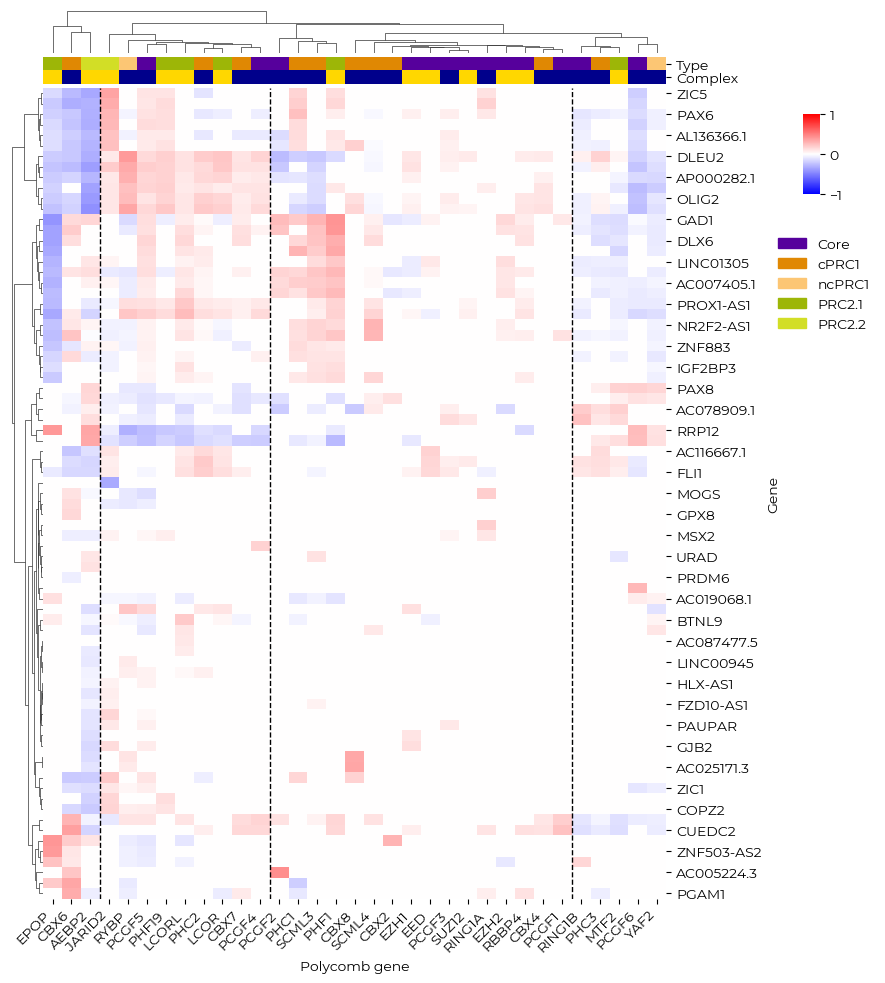

In [56]:
cm = sns.clustermap(csscores.loc[:,~csscores.sum(axis=0).eq(0)].T, 
               col_colors=poly_colors,
               method='ward',
               colors_ratio=0.015,
               figsize=(8,10),
               dendrogram_ratio=0.05,
               cbar_pos=(1.01, 0.8, 0.021, 0.08),
               cmap='bwr', vmin=-1, vmax=1, center=0)

ax = cm.ax_heatmap 
ax.axvline(3, linewidth=1, linestyle='--', c='k')
ax.axvline(12, linewidth=1, linestyle='--', c='k')
ax.axvline(28, linewidth=1, linestyle='--', c='k')

legend_colors = {k:v for k, v in pkgs_types_colors.items() if k != 'Auxillary'}

handles = [mpatches.Patch(color=color, label=label) for label, color in legend_colors.items()]
ax.legend(handles=handles, ncols=1, frameon=False,loc ='upper left', bbox_to_anchor=(1.16, 0.83))

plt.setp(ax.get_xticklabels(), rotation=45, ha='right');